<a href="https://colab.research.google.com/github/esihsi/colab-ML/blob/main/CPADL_Assignment1_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import io


In [79]:
file_path = '/Classification_train.csv'

In [80]:
file_path = '/Classification_train.csv'
cleaned_data = []

try:
    with open(file_path, 'r', newline='') as file:
        # The csv.reader is excellent for handling delimiters and quoted values
        reader = csv.reader(file, delimiter=",")

        for row in reader:
            # Check if the row is not empty
            if row:
                cleaned_data.append(row)

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    # Exit the script or handle the error appropriately
    exit()

df = pd.DataFrame(cleaned_data)

# Set the first row as the header
df.columns = df.iloc[0]

# Drop the first row as it is now the header
df = df[1:].reset_index(drop=True)


# -----------------------------------------------------------------------------
# STEP 4: Convert relevant columns to numeric and handle potential NaNs
# -----------------------------------------------------------------------------
# Convert all columns except 'Label' to float type.
for col in df.columns:
    if col != 'Label':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert 'Label' to numeric, ensuring it's binary (0 or 1).
df['Label'] = pd.to_numeric(df['Label'], errors='coerce').astype(int)
# Ensure 'Label' column only contains 0 and 1, replacing other values with 0.
df['Label'] = df['Label'].apply(lambda x: 1 if x == 1 else 0)
df['Label'] = df['Label'].astype(float)


# Handle NaN values - you might want to fill them with a mean, median, or 0,
# or drop rows with NaNs depending on your data and needs.
# For now, let's fill with 0 as a simple approach.
df.fillna(0, inplace=True)


print("DataFrame loaded and cleaned successfully!")
print("\nFirst 5 rows of the DataFrame after cleaning:")
print(df.head())
df = df.drop(columns=['Date', 'Time'])
X = df.drop(columns=['Label'])
y = df['Label']

DataFrame loaded and cleaned successfully!

First 5 rows of the DataFrame after cleaning:
0  Date  Time  Label  Temperature_F  PIR_1  PIR_2  PIR_3  PIR_4  PIR_5  PIR_6  \
0   0.0   0.0    0.0             86  10269  10721  11156  11170  10931  10671   
1   0.0   0.0    1.0             86  10364  10907  11299  11238  10867  10535   
2   0.0   0.0    0.0             86  10329  10793  11197  11242  11052  10658   
3   0.0   0.0    0.0             86  10169  10425  10822  11133  11136  10834   
4   0.0   0.0    0.0             86  10320  10667  11104  11234  11129  10814   

0  ...  PIR_46  PIR_47  PIR_48  PIR_49  PIR_50  PIR_51  PIR_52  PIR_53  \
0  ...   11178   11197   11161   11096   10957   10839   10735   10590   
1  ...   11122   11145   11136   11108   11041   10824   10645   10493   
2  ...   11168   11204   11162   11109   11007   10867   10700   10533   
3  ...   11116   11273   11186   10984   10910   10807   10714   10651   
4  ...   11006   11257   11370   11173   10924   1081

In [81]:

print(X.info)
print(y.info)

<bound method DataFrame.info of 0     Temperature_F  PIR_1  PIR_2  PIR_3  PIR_4  PIR_5  PIR_6  PIR_7  PIR_8  \
0                86  10269  10721  11156  11170  10931  10671  10395  10133   
1                86  10364  10907  11299  11238  10867  10535  10173   9950   
2                86  10329  10793  11197  11242  11052  10658  10288   9988   
3                86  10169  10425  10822  11133  11136  10834  10520  10228   
4                86  10320  10667  11104  11234  11129  10814  10453  10040   
...             ...    ...    ...    ...    ...    ...    ...    ...    ...   
7646             88  10648  11474  11989  11891  11424  10861  10133   9633   
7647             88  10412  11083  11796  12000  11612  10999  10339   9809   
7648             88  10412  10780  11555  11860  11541  11101  10621  10005   
7649             88  10697  11502  12022  11957  11436  10794  10228   9783   
7650             88  10483  11227  11897  11990  11735  11105  10389   9784   

0     PIR_9  ...  P

In [82]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val) # 0.25 of 0.8 is 0.2


In [83]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (4590, 56), y_train shape: (4590,)
X_val shape: (1530, 56), y_val shape: (1530,)
X_test shape: (1531, 56), y_test shape: (1531,)


In [84]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [86]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1) # unsqueeze for binary classification loss
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


In [87]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


In [88]:
batch_size = 64 # A common batch size, but this is one of the experiment ideas to vary[cite: 66].
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [89]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn):
        super(MLP, self).__init__()
        layers = []
        # First layer from input to first hidden layer
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(activation_fn)

        # Hidden layers
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(activation_fn)

        # Output layer for binary classification
        layers.append(nn.Linear(hidden_layers[-1], 1))
        layers.append(nn.Sigmoid()) # Sigmoid is the correct activation for the output of binary classification[cite: 62].

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [90]:
def train_and_evaluate(model, train_loader, val_loader, num_epochs, learning_rate, device):
    criterion = nn.BCELoss() # Binary Cross-Entropy Loss is standard for binary classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Store history for plotting
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_loss_history.append(epoch_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    return train_loss_history, val_loss_history


In [91]:
# Function to get predictions and calculate metrics
def get_metrics(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())
            y_pred.extend((outputs > 0.5).cpu().numpy())

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    y_scores = np.array(y_scores).flatten()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_scores)
    conf_matrix = confusion_matrix(y_true, y_pred)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc_score': roc_auc,
        'confusion_matrix': conf_matrix
    }


In [92]:
# Function to plot training loss curves
def plot_loss_curves(train_loss, val_loss, title="Loss Curves"):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


Using device: cpu
--- Experiment 1: Impact of Number of Hidden Layers ---

Training with 1 hidden layers: [64]
Epoch [1/20], Train Loss: 0.4342, Val Loss: 0.3093
Epoch [2/20], Train Loss: 0.2723, Val Loss: 0.2266
Epoch [3/20], Train Loss: 0.1956, Val Loss: 0.1643
Epoch [4/20], Train Loss: 0.1467, Val Loss: 0.1305
Epoch [5/20], Train Loss: 0.1150, Val Loss: 0.1053
Epoch [6/20], Train Loss: 0.0934, Val Loss: 0.0886
Epoch [7/20], Train Loss: 0.0786, Val Loss: 0.0797
Epoch [8/20], Train Loss: 0.0687, Val Loss: 0.0715
Epoch [9/20], Train Loss: 0.0605, Val Loss: 0.0683
Epoch [10/20], Train Loss: 0.0553, Val Loss: 0.0608
Epoch [11/20], Train Loss: 0.0492, Val Loss: 0.0579
Epoch [12/20], Train Loss: 0.0448, Val Loss: 0.0532
Epoch [13/20], Train Loss: 0.0413, Val Loss: 0.0517
Epoch [14/20], Train Loss: 0.0388, Val Loss: 0.0521
Epoch [15/20], Train Loss: 0.0369, Val Loss: 0.0484
Epoch [16/20], Train Loss: 0.0348, Val Loss: 0.0483
Epoch [17/20], Train Loss: 0.0323, Val Loss: 0.0470
Epoch [18/20],

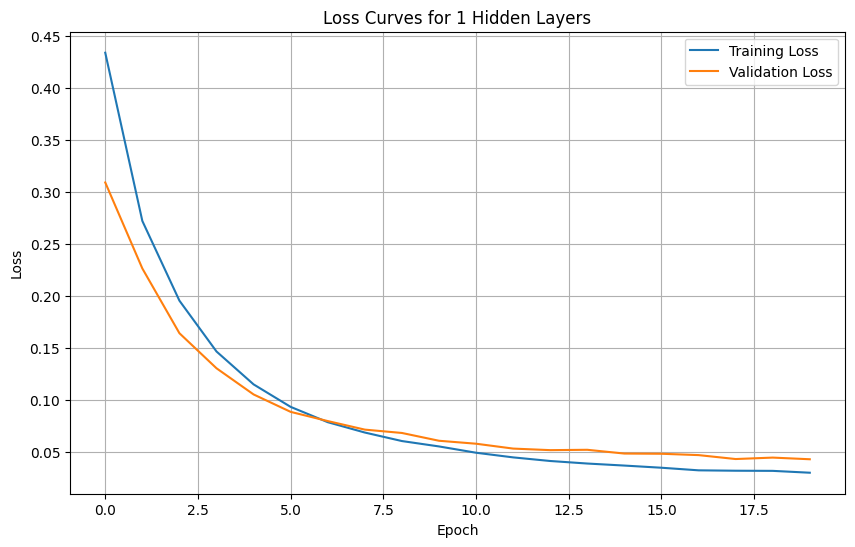

Validation Metrics:
  accuracy: 0.9817
  precision: 0.8971
  recall: 0.9401
  f1_score: 0.9181
  roc_auc_score: 0.9975
  Confusion Matrix:
[[1345   18]
 [  10  157]]

Training with 2 hidden layers: [64, 32]
Epoch [1/20], Train Loss: 0.4120, Val Loss: 0.2220
Epoch [2/20], Train Loss: 0.1699, Val Loss: 0.1229
Epoch [3/20], Train Loss: 0.0940, Val Loss: 0.0738
Epoch [4/20], Train Loss: 0.0634, Val Loss: 0.0573
Epoch [5/20], Train Loss: 0.0442, Val Loss: 0.0460
Epoch [6/20], Train Loss: 0.0360, Val Loss: 0.0428
Epoch [7/20], Train Loss: 0.0321, Val Loss: 0.0416
Epoch [8/20], Train Loss: 0.0355, Val Loss: 0.0439
Epoch [9/20], Train Loss: 0.0254, Val Loss: 0.0381
Epoch [10/20], Train Loss: 0.0237, Val Loss: 0.0419
Epoch [11/20], Train Loss: 0.0228, Val Loss: 0.0324
Epoch [12/20], Train Loss: 0.0188, Val Loss: 0.0359
Epoch [13/20], Train Loss: 0.0191, Val Loss: 0.0341
Epoch [14/20], Train Loss: 0.0174, Val Loss: 0.0349
Epoch [15/20], Train Loss: 0.0178, Val Loss: 0.0366
Epoch [16/20], Train L

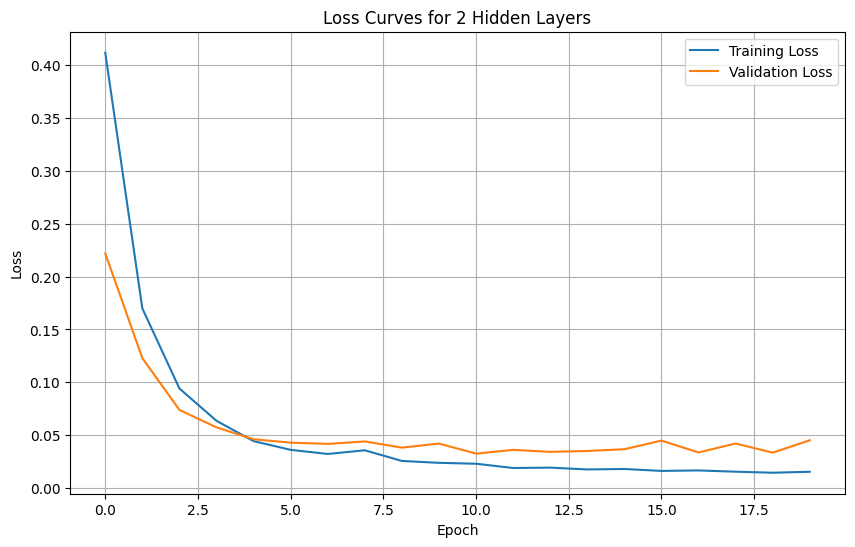

Validation Metrics:
  accuracy: 0.9856
  precision: 0.9096
  recall: 0.9641
  f1_score: 0.9360
  roc_auc_score: 0.9975
  Confusion Matrix:
[[1347   16]
 [   6  161]]

Training with 3 hidden layers: [64, 32, 16]
Epoch [1/20], Train Loss: 0.5171, Val Loss: 0.2947
Epoch [2/20], Train Loss: 0.2059, Val Loss: 0.1224
Epoch [3/20], Train Loss: 0.1067, Val Loss: 0.0668
Epoch [4/20], Train Loss: 0.0725, Val Loss: 0.0560
Epoch [5/20], Train Loss: 0.0599, Val Loss: 0.0513
Epoch [6/20], Train Loss: 0.0559, Val Loss: 0.0504
Epoch [7/20], Train Loss: 0.0520, Val Loss: 0.0436
Epoch [8/20], Train Loss: 0.0455, Val Loss: 0.0459
Epoch [9/20], Train Loss: 0.0435, Val Loss: 0.0462
Epoch [10/20], Train Loss: 0.0408, Val Loss: 0.0414
Epoch [11/20], Train Loss: 0.0401, Val Loss: 0.0454
Epoch [12/20], Train Loss: 0.0429, Val Loss: 0.0511
Epoch [13/20], Train Loss: 0.0388, Val Loss: 0.0407
Epoch [14/20], Train Loss: 0.0394, Val Loss: 0.1147
Epoch [15/20], Train Loss: 0.0381, Val Loss: 0.0402
Epoch [16/20], Tra

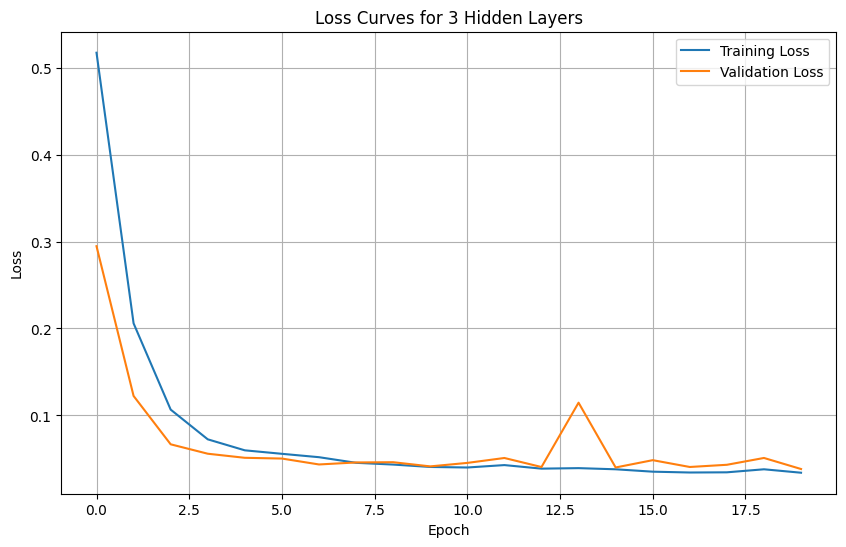

Validation Metrics:
  accuracy: 0.9856
  precision: 0.9677
  recall: 0.8982
  f1_score: 0.9317
  roc_auc_score: 0.9983
  Confusion Matrix:
[[1358    5]
 [  17  150]]


In [95]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# The number of input features is the number of columns in X_train
input_size = X_train.shape[1]

# This is where you will implement your experiments.
# You need to perform at least three distinct experiments.

#---------------------------------------------
# Experiment 1: Impact of Number of Hidden Layers
#---------------------------------------------
print("--- Experiment 1: Impact of Number of Hidden Layers ---")

num_epochs = 20
learning_rate = 0.001
activation_fn = nn.ReLU() # ReLU is a good starting choice[cite: 62].

# Define different hidden layer configurations to test[cite: 58].
hidden_layer_configs = [
    [64],            # 1 hidden layer
    [64, 32],        # 2 hidden layers
    [64, 32, 16]     # 3 hidden layers
]

for config in hidden_layer_configs:
    print(f"\nTraining with {len(config)} hidden layers: {config}")

    model = MLP(input_size, config, activation_fn).to(device)

    # Train the model
    train_loss, val_loss = train_and_evaluate(model, train_loader, val_loader, num_epochs, learning_rate, device)

    # Plot the loss curves
    plot_loss_curves(train_loss, val_loss, title=f"Loss Curves for {len(config)} Hidden Layers")

    # Evaluate on the validation set
    val_metrics = get_metrics(model, val_loader, device)

    print("Validation Metrics:")
    for metric, value in val_metrics.items():
        if metric == 'confusion_matrix':
            print(f"  Confusion Matrix:\n{value}")
        else:
            print(f"  {metric}: {value:.4f}")

    # IMPORTANT: On submission day, you will evaluate on the released test set instead of val_loader.
    # test_metrics = get_metrics(model, test_loader, device)
    # print("\nTest Metrics (to be reported on submission day):")
    # for metric, value in test_metrics.items():
    #     if metric == 'confusion_matrix':
    #         print(f"  Confusion Matrix:\n{value}")
    #     else:
    #         print(f"  {metric}: {value:.4f}")




--- Experiment 2: Learning Rate Tuning ---

Training with Learning Rate: 0.01
Epoch [1/20], Train Loss: 0.1482, Val Loss: 0.0618
Epoch [2/20], Train Loss: 0.0539, Val Loss: 0.0517
Epoch [3/20], Train Loss: 0.0465, Val Loss: 0.0474
Epoch [4/20], Train Loss: 0.0473, Val Loss: 0.0487
Epoch [5/20], Train Loss: 0.0410, Val Loss: 0.0412
Epoch [6/20], Train Loss: 0.0348, Val Loss: 0.0665
Epoch [7/20], Train Loss: 0.0429, Val Loss: 0.0595
Epoch [8/20], Train Loss: 0.0331, Val Loss: 0.0455
Epoch [9/20], Train Loss: 0.0392, Val Loss: 0.0439
Epoch [10/20], Train Loss: 0.0440, Val Loss: 0.2428
Epoch [11/20], Train Loss: 0.0739, Val Loss: 0.0425
Epoch [12/20], Train Loss: 0.0532, Val Loss: 0.0398
Epoch [13/20], Train Loss: 0.0398, Val Loss: 0.0395
Epoch [14/20], Train Loss: 0.0374, Val Loss: 0.0321
Epoch [15/20], Train Loss: 0.0353, Val Loss: 0.1157
Epoch [16/20], Train Loss: 0.0340, Val Loss: 0.0437
Epoch [17/20], Train Loss: 0.0482, Val Loss: 0.1746
Epoch [18/20], Train Loss: 0.0388, Val Loss: 0

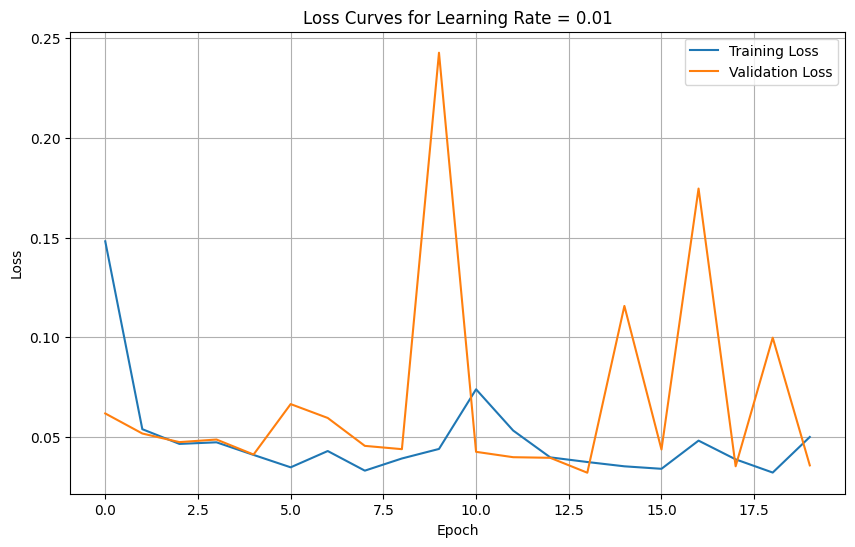

Validation Metrics:
  accuracy: 0.9876
  precision: 0.9684
  recall: 0.9162
  f1_score: 0.9415
  roc_auc_score: 0.9983
  Confusion Matrix:
[[1358    5]
 [  14  153]]

Training with Learning Rate: 0.001
Epoch [1/20], Train Loss: 0.4804, Val Loss: 0.2742
Epoch [2/20], Train Loss: 0.2130, Val Loss: 0.1522
Epoch [3/20], Train Loss: 0.1113, Val Loss: 0.0847
Epoch [4/20], Train Loss: 0.0675, Val Loss: 0.0660
Epoch [5/20], Train Loss: 0.0484, Val Loss: 0.0692
Epoch [6/20], Train Loss: 0.0402, Val Loss: 0.0467
Epoch [7/20], Train Loss: 0.0328, Val Loss: 0.0386
Epoch [8/20], Train Loss: 0.0284, Val Loss: 0.0369
Epoch [9/20], Train Loss: 0.0254, Val Loss: 0.0347
Epoch [10/20], Train Loss: 0.0238, Val Loss: 0.0313
Epoch [11/20], Train Loss: 0.0209, Val Loss: 0.0316
Epoch [12/20], Train Loss: 0.0201, Val Loss: 0.0339
Epoch [13/20], Train Loss: 0.0188, Val Loss: 0.0309
Epoch [14/20], Train Loss: 0.0188, Val Loss: 0.0371
Epoch [15/20], Train Loss: 0.0189, Val Loss: 0.0334
Epoch [16/20], Train Loss: 

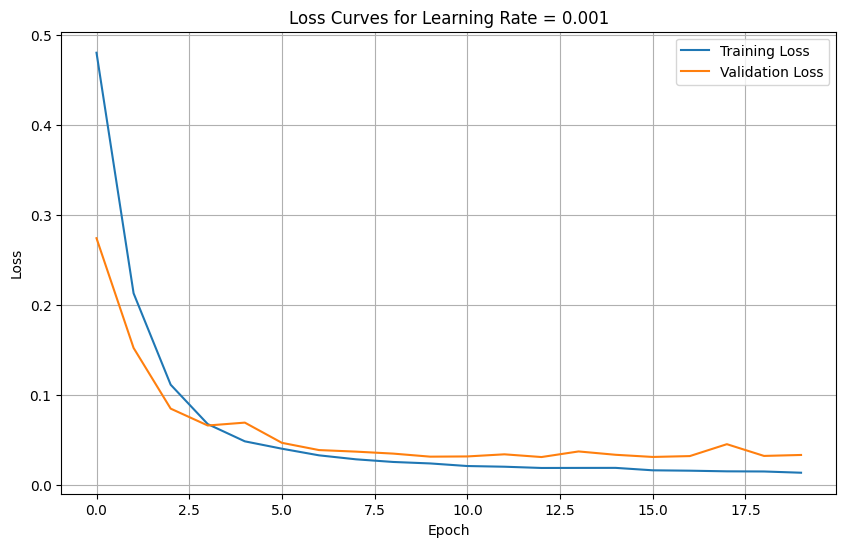

Validation Metrics:
  accuracy: 0.9876
  precision: 0.9568
  recall: 0.9281
  f1_score: 0.9422
  roc_auc_score: 0.9984
  Confusion Matrix:
[[1356    7]
 [  12  155]]

Training with Learning Rate: 0.0001
Epoch [1/20], Train Loss: 0.6747, Val Loss: 0.6490
Epoch [2/20], Train Loss: 0.6244, Val Loss: 0.5860
Epoch [3/20], Train Loss: 0.5502, Val Loss: 0.4978
Epoch [4/20], Train Loss: 0.4617, Val Loss: 0.4105
Epoch [5/20], Train Loss: 0.3875, Val Loss: 0.3501
Epoch [6/20], Train Loss: 0.3383, Val Loss: 0.3114
Epoch [7/20], Train Loss: 0.3043, Val Loss: 0.2828
Epoch [8/20], Train Loss: 0.2766, Val Loss: 0.2580
Epoch [9/20], Train Loss: 0.2516, Val Loss: 0.2354
Epoch [10/20], Train Loss: 0.2288, Val Loss: 0.2148
Epoch [11/20], Train Loss: 0.2082, Val Loss: 0.1961
Epoch [12/20], Train Loss: 0.1897, Val Loss: 0.1795
Epoch [13/20], Train Loss: 0.1732, Val Loss: 0.1646
Epoch [14/20], Train Loss: 0.1585, Val Loss: 0.1519
Epoch [15/20], Train Loss: 0.1455, Val Loss: 0.1391
Epoch [16/20], Train Loss:

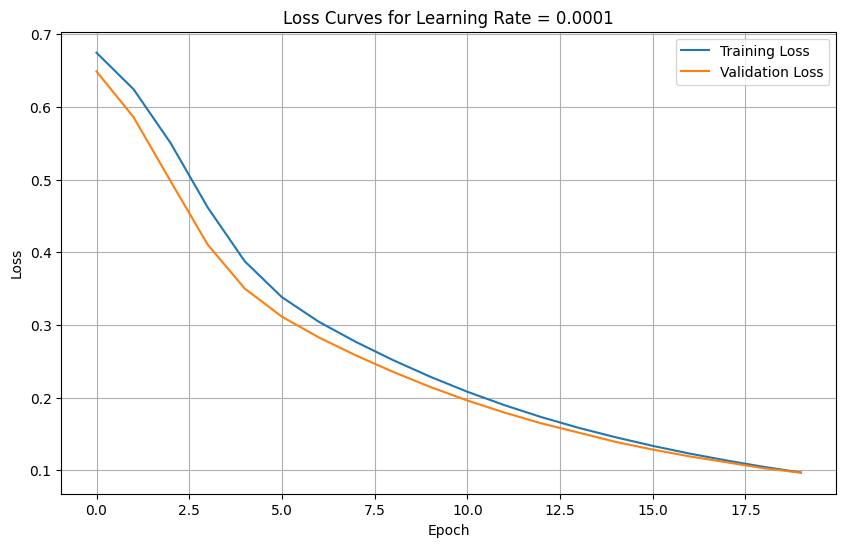

Validation Metrics:
  accuracy: 0.9778
  precision: 0.9080
  recall: 0.8862
  f1_score: 0.8970
  roc_auc_score: 0.9919
  Confusion Matrix:
[[1348   15]
 [  19  148]]


In [96]:
print("\n--- Experiment 2: Learning Rate Tuning ---")

# Fix a reasonable model architecture
fixed_hidden_layers = [64, 32]
num_epochs = 20
activation_fn = nn.ReLU()

# Experiment with different learning rates[cite: 64].
learning_rates = [0.01, 0.001, 0.0001]

for lr in learning_rates:
    print(f"\nTraining with Learning Rate: {lr}")

    model = MLP(input_size, fixed_hidden_layers, activation_fn).to(device)

    # Train the model
    train_loss, val_loss = train_and_evaluate(model, train_loader, val_loader, num_epochs, lr, device)

    # Plot the loss curves to visualize the effect on convergence[cite: 65].
    plot_loss_curves(train_loss, val_loss, title=f"Loss Curves for Learning Rate = {lr}")

    # Evaluate on the validation set
    val_metrics = get_metrics(model, val_loader, device)

    print("Validation Metrics:")
    for metric, value in val_metrics.items():
        if metric == 'confusion_matrix':
            print(f"  Confusion Matrix:\n{value}")
        else:
            print(f"  {metric}: {value:.4f}")




--- Experiment 3: Choice of Activation Function ---

Training with Activation Function: ReLU
Epoch [1/20], Train Loss: 0.4088, Val Loss: 0.2421
Epoch [2/20], Train Loss: 0.1866, Val Loss: 0.1342
Epoch [3/20], Train Loss: 0.0987, Val Loss: 0.0773
Epoch [4/20], Train Loss: 0.0599, Val Loss: 0.0568
Epoch [5/20], Train Loss: 0.0445, Val Loss: 0.0492
Epoch [6/20], Train Loss: 0.0365, Val Loss: 0.0425
Epoch [7/20], Train Loss: 0.0315, Val Loss: 0.0427
Epoch [8/20], Train Loss: 0.0263, Val Loss: 0.0375
Epoch [9/20], Train Loss: 0.0235, Val Loss: 0.0348
Epoch [10/20], Train Loss: 0.0236, Val Loss: 0.0402
Epoch [11/20], Train Loss: 0.0258, Val Loss: 0.0385
Epoch [12/20], Train Loss: 0.0193, Val Loss: 0.0304
Epoch [13/20], Train Loss: 0.0194, Val Loss: 0.0344
Epoch [14/20], Train Loss: 0.0210, Val Loss: 0.0349
Epoch [15/20], Train Loss: 0.0251, Val Loss: 0.0372
Epoch [16/20], Train Loss: 0.0193, Val Loss: 0.0334
Epoch [17/20], Train Loss: 0.0172, Val Loss: 0.0331
Epoch [18/20], Train Loss: 0.01

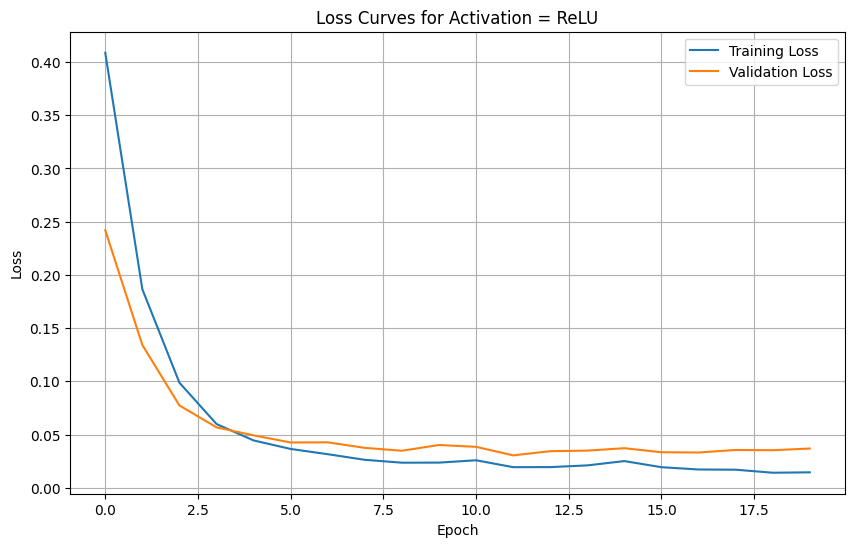

Validation Metrics:
  accuracy: 0.9856
  precision: 0.9448
  recall: 0.9222
  f1_score: 0.9333
  roc_auc_score: 0.9979
  Confusion Matrix:
[[1354    9]
 [  13  154]]

Training with Activation Function: Tanh
Epoch [1/20], Train Loss: 0.3988, Val Loss: 0.2103
Epoch [2/20], Train Loss: 0.1285, Val Loss: 0.0886
Epoch [3/20], Train Loss: 0.0611, Val Loss: 0.0617
Epoch [4/20], Train Loss: 0.0428, Val Loss: 0.0528
Epoch [5/20], Train Loss: 0.0335, Val Loss: 0.0531
Epoch [6/20], Train Loss: 0.0288, Val Loss: 0.0487
Epoch [7/20], Train Loss: 0.0301, Val Loss: 0.0471
Epoch [8/20], Train Loss: 0.0247, Val Loss: 0.0415
Epoch [9/20], Train Loss: 0.0223, Val Loss: 0.0424
Epoch [10/20], Train Loss: 0.0209, Val Loss: 0.0565
Epoch [11/20], Train Loss: 0.0197, Val Loss: 0.0534
Epoch [12/20], Train Loss: 0.0187, Val Loss: 0.0426
Epoch [13/20], Train Loss: 0.0175, Val Loss: 0.0608
Epoch [14/20], Train Loss: 0.0189, Val Loss: 0.0419
Epoch [15/20], Train Loss: 0.0202, Val Loss: 0.0424
Epoch [16/20], Train L

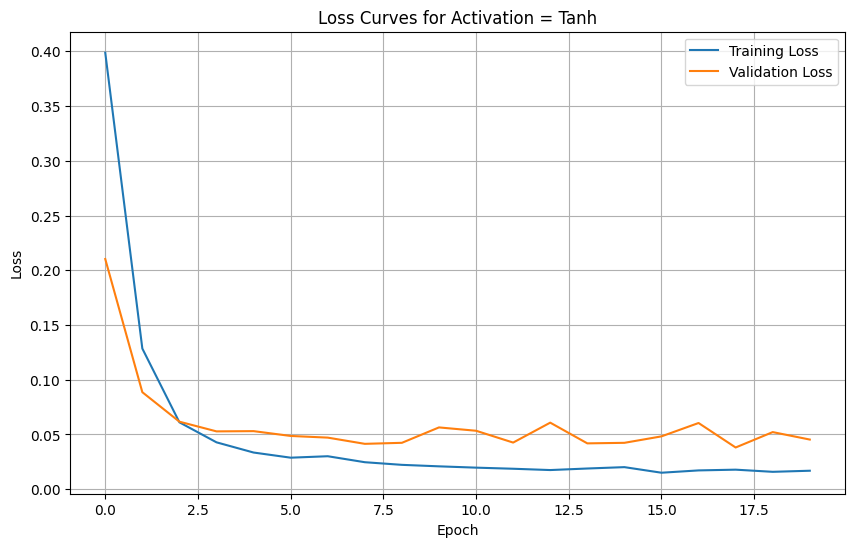

Validation Metrics:
  accuracy: 0.9869
  precision: 0.9061
  recall: 0.9820
  f1_score: 0.9425
  roc_auc_score: 0.9977
  Confusion Matrix:
[[1346   17]
 [   3  164]]


In [97]:
#---------------------------------------------
# Experiment 3: Choice of Activation Function
#---------------------------------------------
print("\n--- Experiment 3: Choice of Activation Function ---")

# Fix a reasonable model architecture and learning rate
fixed_hidden_layers = [64, 32]
num_epochs = 20
learning_rate = 0.001

# Compare different activation functions[cite: 62].
activation_functions = {
    'ReLU': nn.ReLU(),
    'Tanh': nn.Tanh()
    # 'Sigmoid': nn.Sigmoid() # Not recommended for hidden layers[cite: 62].
}

for name, act_fn in activation_functions.items():
    print(f"\nTraining with Activation Function: {name}")

    # The MLP class needs to be slightly modified to handle sigmoid for hidden layers if you want to test it.
    # The current class uses sigmoid only for the output layer.
    class MLP_with_Any_Activation(nn.Module):
        def __init__(self, input_size, hidden_layers, activation_fn):
            super(MLP_with_Any_Activation, self).__init__()
            layers = []
            layers.append(nn.Linear(input_size, hidden_layers[0]))
            layers.append(activation_fn)
            for i in range(len(hidden_layers) - 1):
                layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
                layers.append(activation_fn)
            layers.append(nn.Linear(hidden_layers[-1], 1))
            layers.append(nn.Sigmoid())
            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    model = MLP_with_Any_Activation(input_size, fixed_hidden_layers, act_fn).to(device)

    # Train the model
    train_loss, val_loss = train_and_evaluate(model, train_loader, val_loader, num_epochs, learning_rate, device)
        # Plot the loss curves
    plot_loss_curves(train_loss, val_loss, title=f"Loss Curves for Activation = {name}")

    # Evaluate on the validation set
    val_metrics = get_metrics(model, val_loader, device)

    print("Validation Metrics:")
    for metric, value in val_metrics.items():
        if metric == 'confusion_matrix':
            print(f"  Confusion Matrix:\n{value}")
        else:
            print(f"  {metric}: {value:.4f}")
